In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
data = load_coco_data(pca_features=False)

In [4]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()    

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

val_urls <class 'numpy.ndarray'> (40504,) <U63
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
word_embedding <class 'numpy.ndarray'> (1004, 304) float64
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
train_urls <class 'numpy.ndarray'> (82783,) <U63
word_to_idx <class 'dict'> 1004
train_features <class 'numpy.ndarray'> (82783, 4096) float32
idx_to_word <class 'list'> 1004


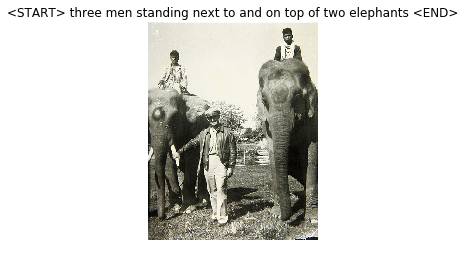

In [6]:
show_image(1)

In [7]:
def group_image_index_by_image_id(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_image_index_to_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_image_index_to_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sample_image, sample_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sample_image.shape) * -1
    return np.concatenate([demo_image, sample_image], axis=0), np.concatenate([demo_caption, sample_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)

def remove_start_token(captions_with_start_token):
    return np.array([c[1:] for c in captions_with_start_token])


In [8]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)

In [9]:
image_ids = data['train_image_idxs']
captions = data['train_captions']
idx_to_word = data['idx_to_word']

# create random pairing
grouped_image_index = group_image_index_by_image_id(image_ids)
grouped_captions = map_image_index_to_captions(captions, grouped_image_index)
scrambled_captions = scramble_image_caption_pairs(captions, grouped_image_index)

# merge both, and retain flag
image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions)
image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_captions)

demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.zeros(image_idx_sampled.shape)))

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## Model Param

In [11]:

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]
enable_preprocessed_embedding = True

if enable_preprocessed_embedding:
    word_embedding_dim = data['word_embedding'].shape[1]
else:
    word_embedding_dim = 256

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
UNK_TOKEN = '<UNK>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]
START_ID = data['word_to_idx'][START_TOKEN]
END_ID = data['word_to_idx'][END_TOKEN]
UNK_ID = data['word_to_idx'][UNK_TOKEN]

## model params
hidden_dim = 512
learning_rate = 1e-3

print("Vocab Dim: %i\nImage Feature Dim: %i\nWord Embedding Dim: %i"%(vocab_dim, image_feature_dim, word_embedding_dim))

Vocab Dim: 1004
Image Feature Dim: 4096
Word Embedding Dim: 304


## Model Architecture

In [12]:
from discriminator import CaptionInput, ImageInput, MetadataInput, Discriminator

In [13]:
tf.reset_default_graph()
caption_input = CaptionInput(word_embedding_init=data['word_embedding'],null_id=NULL_ID)
image_input = ImageInput(image_feature_dim=image_feature_dim, hidden_dim=hidden_dim)
metadata_input = MetadataInput()

In [14]:
discr = Discriminator(caption_input, image_input, metadata_input)

## Training

In [15]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [18]:
import time

def get_image_features(image_ids):
    return data['train_features'][image_ids]

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)
    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)
    not_null_mask_batch = caption_batch != NULL_ID
    # to randomize here
    
    return image_idx_batch, caption_batch, not_null_mask_batch, demo_or_sampled_batch

iter_num = 10
batch_size = 1000

t0 = time.time()
for i in range(iter_num):
    
    image_idx_batch, caption_batch, not_null_mask, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    
    image_feats_batch = get_image_features(image_idx_batch)
    
    caption_input.pre_feed(caption_word_ids=caption_batch)
    image_input.pre_feed(image_proj=image_feats_batch)
    metadata_input.pre_feed(demo_or_sampled_batch)
    r, m = discr.train(sess)
    
    print("iter {}, loss: {}".format(i,r))
t1 = time.time()
print ("Time taken: ", t1-t0)

iter 0, loss: -0.10228469967842102
iter 1, loss: -0.14738796651363373
iter 2, loss: -0.11537354439496994
iter 3, loss: -0.09784408658742905
iter 4, loss: -0.1923830807209015
iter 5, loss: -0.2077171355485916
iter 6, loss: -0.19619715213775635
iter 7, loss: -0.2326669543981552
iter 8, loss: -0.32162415981292725
iter 9, loss: -0.31813615560531616
Time taken:  94.91876006126404


In [ ]:
demo_or_sampled_batch[846], decode_captions(caption_batch[846], idx_to_word), 

In [ ]:
def test_run(img_feature_test, caption_test):
    not_null_mask_test = caption_test != NULL_ID
    m = sess.run(masked_reward, feed_dict=
                   {sy_image_feat_input: img_feature_test,
                    sy_caption_input: caption_test, 
                    sy_not_null_mask: not_null_mask_test})
    sum_not_null = np.sum(not_null_mask_test, axis=1)
    me = np.sum(m, axis=1) / sum_not_null
    return m, me
                           
def convert_to_word_ids(captions):
    max_len = max([len(c) for c in captions])
    caption_ids = np.ones((len(captions), max_len), dtype=np.int) * NULL_ID
    for i, c in enumerate(captions):
        for j, tk in enumerate(c):
            if tk in data['word_to_idx']:
                caption_ids[i, j] = data['word_to_idx'][tk]
            else:
                caption_ids[i, j] = UNK_ID
    return caption_ids

def assign_reward(img_ids, captions):
    image_feats_test = get_image_features(img_ids)
    caption_test = convert_to_word_ids(captions)
    reward_per_token, mean_reward = test_run(image_feats_test, caption_test)
    examine(img_ids, caption_test, reward_per_token, mean_reward)
    
def examine(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        plt.imshow(image_from_url(data['train_urls'][img]))
        plt.axis('off')
        plt.show()   
        decoded = decode_captions(cap, idx_to_word).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == -1 )[0], num_to_examine)
    examine_sample(chosen)


In [ ]:
image_to_test = np.array([99, 1010])
captions_to_test = ["<START> zoo with monkey and children <END>".split(), "<START> people are dining and talking on a long table <END>".split()]
assign_reward(image_to_test, captions_to_test)

In [ ]:
examine_batch_results(demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

In [ ]:
diff_func = lambda x1, x2 : x2-x1
tf.scan(diff_func, tf.constant([[[12,3],[8,9]] ,[[12,3],[8,9]]])).eval()

In [ ]:
np.ones((3,4,5)).shape

In [ ]:
np.ones((3,4,5))[:,0,:].shape

In [ ]:

a = tf.constant(np.ones((3,4,5)))
tf.concat([ tf.expand_dims(a[:,0,:], dim=1),  a[:,1:4,:] - a[:,0:3,:]], axis=1).eval()


In [ ]:
## x[:,1:T] and x[:, 0:T-1]
## Reuse RNN weight with same scope


## Losses

# R average reward per each token over the sentence
# -1 * (R(correct) - R(mismatch))
# Max(0,  - R(correct) + R(mismtach))
# Triplet loss anchor

# Reward as attention token to be able to predict yes/no

# Difference between hidden state (to model direction of the sentence in a good caption)

# 

In [ ]:
tf.where(lambda x: x==1, 20, -20,  tf.constant(np.ones((1,2,3))).eval()